# Innate Binocular Visual Learning Project
### Final Project for COMP 386: Computational Neuroscience
#### Worked on by:
- Sam Sendelbach
- David Saffo
- Mary Makarious

#### Project Summary
[Copy paste]

---

##### Necessary Packages to Import 

In [1]:
from numpy import *
import pylab
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import PIL
%matplotlib inline

---

##### [Insert Description Here]

In [2]:
def distance(x0, y0, x1, y1):
  return sqrt(pow(x0-x1,2) + pow(y0-y1,2))

class LGN: 
  """
  this class defines a model which generates binocular spontaneous activity
  """
  
  def __init__(self, width = 128, p = 0.5, r = 1.0, t = 1, trans = 0.0,
    make_wave = True, num_layers=2, random_seed=0):
    random.seed(random_seed)
    self.width = width
    self.p = p
    self.r = r
    self.t = t
    self.trans = trans
    self.num_layers = num_layers
    if make_wave:
      self.reset_wave()

  def reset_wave(self):
    """ create another random wave """
    # setting up the network
    w = self.width
    self.recruitable = random.rand(self.num_layers, w, w) < self.p
    self.tot_recruitable = len(where(self.recruitable)[0])
    self.tot_recruitable_active = 0
    self.tot_active = 0
    self.active = zeros([self.num_layers,w,w],bool)
    self.active_neighbors = zeros([self.num_layers,w,w],int)
    self.activated = []; # the recently active nodes
    
    if self.tot_recruitable > 0:
      while self.fraction_active() < 0.2:
        self.activate()  

  def fraction_active(self):
    """ returns the fraction of potentially recruitable cells which are active """
    if self.tot_recruitable > 0:
      return float(self.tot_recruitable_active) / self.tot_recruitable
    else:
      return nan

  def propagate(self):
    """ propagate the activity if a valid node has been activated """
    # activated only has recruitable and currently inactive members
    while len(self.activated) > 0:
      act_l, act_x, act_y = self.activated.pop()
      self.active[act_l,act_x,act_y] = True
      self.tot_active += 1
      self.tot_recruitable_active += 1
      for l in range(self.num_layers):
        for x in range(int(act_x-self.r),int(act_x+self.r+1)):
          for y in range(int(act_y-self.r),int(act_y+self.r+1)):
            if distance(act_x,act_y,x,y) <= self.r:
              xi = x % self.width
              yi = y % self.width
              if l != act_l: # spread the activity across layers
                if random.rand() < self.trans: # transfer the activity
                  self.active_neighbors[l, xi,yi] += 1
              else: # if it is the same layer
                self.active_neighbors[l, xi,yi] += 1
              if self.active_neighbors[l, xi,yi] == self.t and \
                not self.active[l, xi,yi]:
                if self.recruitable[l, xi,yi]:
                  self.activated.append([l, xi,yi])
                else: # activate the node but don't propagate the activity
                  self.active[l,xi,yi] = True
                  self.tot_active += 1

  def activate(self):
    """ activate a random potentially active node """
    if self.fraction_active() > 0.95:
      return
      
    # pick a random point
    while True:
      l = random.randint(0,self.num_layers)
      x = random.randint(0,self.width)
      y = random.randint(0,self.width)
      if (self.recruitable[l,x,y] and not self.active[l,x,y]):
        break
    self.activated.append([l,x,y])
    self.propagate()

  def correlation(self):
    """ returns the correlation between the left and right images """
    # the total number of activations in common
    # same_count = len(where(self.active[0,:,:] == self.active[1,:,:])[0])
    # return float(same_count) / (self.width * self.width)
    
    # create an activity matrix of 0's and 1's (instead of True and False)
    if self.num_layers < 2:
      print("monocular models cannot have correlations between eye layers")
      return 0
    w = self.width
    active01 = zeros([2,w,w],int)
    active01[where(self.active)] = 1
    
    mean0 = active01[0,:,:].mean()
    mean1 = active01[1,:,:].mean()
    std0 = active01[0,:,:].std()
    std1 = active01[1,:,:].std()
    cov = ((active01[0,:,:] - mean0) * (active01[1,:,:] - mean1)).mean()
    return cov / (std0 * std1)
    
    
  def make_img_mat(self, show_img=True):
    """ return a matrix of 1's and 0's showing the activity in both layers """
    img_array = zeros([self.num_layers,self.width,self.width])
    border_width = 10 if self.num_layers > 1 else 0
    w = self.width
    for l in range(self.num_layers):
        img = zeros([w, w], float)
        for x in range(0,w-1):
            for y in range(0,w-1):
                if self.active[l,x,y]:
                    img[x,y] = 1
                    
    
        img_array[l] = img         
        plt.imshow(img)
        plt.show()
        
    return img_array


##### [Description Here]

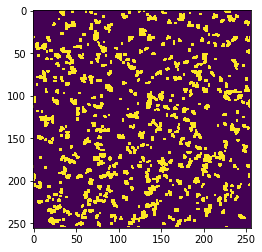

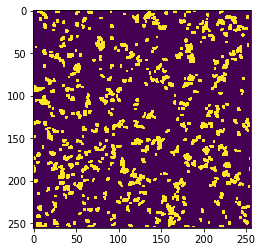

In [3]:
L = LGN(width = 256, p = 0.2, r = 1.5, t = 1, trans = 0.0, make_wave = True, num_layers=2, random_seed=5)
images = L.make_img_mat()

#### Parameters 
- p = recrutable cells (cell spacing, chemical inhibition, recovery speed)
- r = similar to "dendritic field size" (radius)
- t = threshold (how many neighbors are are needed to activate)
- trans = probability of transmitting activity from one eye layer to the next (cross-talk between layers)

---

In [4]:
import scipy.misc
from IPython.display import Image, Audio
scipy.misc.imsave('imgs/1.tiff', images[0])
scipy.misc.imsave('imgs/2.tiff', images[1])

##### Extracting Patches

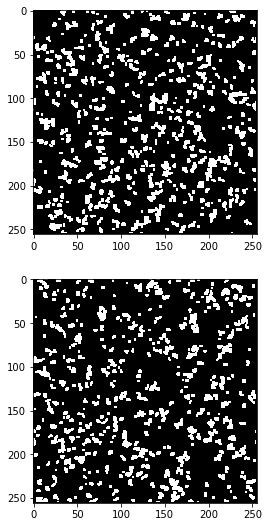

In [5]:
# packages used among multiple sections

import sklearn.decomposition # For FastICA and PCA
from IPython.display import Image, Audio

# setting up interactive plotting
import pylab as py
# to show plots directly in the notebook
%matplotlib inline

import numpy as np
# just changes precision for printing, easier on the eyes
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True) # to supress exponential notation
import matplotlib.image as mpimg
import PIL.Image

show_these = ['1.tiff','2.tiff'] # there are 1-13.tiff's

# read in images and display from array form - fix: could be simpler
fig = py.figure(figsize=(8,14))
for (i,file) in enumerate(show_these):
    py.subplot(3,1,i+1)
    img = PIL.Image.open('imgs/'+file)
    py.imshow(img, cmap=py.cm.Greys_r)

In [15]:
# time to collect some small random patches from those images
import numpy as np
def collect_natural_patches(img, num_patches = 5000, patch_width = 8, downsample=2):
  """ collects image patches, in the same way as the LGN model, for analysis 
  the natural images are from a specific folder of 13 .tiff files"""

  from PIL import Image
  max_tries = num_patches * 50
  image_width = 200
  
  img_first_patch = 0 # the first patch number accepted from an image
  img_first_try = 0 # the first attempt to take a patch from the image
  patch_cnt = 0
  try_cnt = 0
  ds = downsample
  w = patch_width * ds
  d = w * w
  d_final = patch_width * patch_width
  avg_filt = np.ones([ds, ds],'float') / ds**2

  layer_patch = np.zeros([1,w,w],float)
  down_patch = np.zeros([1,patch_width,patch_width],'float')  
  patch = np.zeros([d,1],float)
  
  img_patches = np.zeros( [d_final,num_patches],float)

  # change the image sampled from
  nat_img_cnt = 1  
  active = Image.open(img)
  active = np.asarray(active, 'double').transpose()  
  # normalizing the activity image
  active -= active.mean()
  active /= active.std()
      
  # collect the patches
  while patch_cnt < num_patches and try_cnt < max_tries:
    try_cnt += 1  # number of total patches attempted

    if (try_cnt - img_first_try) > 50000 or \
      (patch_cnt - img_first_patch) > num_patches/12:
      # change the image sampled from
      
      active = Image.open(img)
      active = np.asarray(active, 'double').transpose()        
      # normalizing the activity image
      active -= active.mean()
      active /= active.std()
      
      img_first_patch = patch_cnt
      img_first_try = try_cnt
      print (float(patch_cnt)/num_patches)
    
    px = np.random.randint(0,image_width - w)
    py = np.random.randint(0,image_width - w)
        
    layer_patch[0,:,:] = active[px:px+w,py:py+w].copy()
    patch_std = layer_patch.std()
    
    if patch_std > 0.0:
      # create the patch vector
      # downsample the patch
      for x in range(patch_width):
        for y in range(patch_width):
          down_patch[0,x,y] = np.sum(avg_filt * layer_patch[0,ds*x:ds*x+ds,ds*y:ds*y+ds])      
      patch = np.reshape(down_patch, d_final)     
      patch = patch - np.mean(patch)         
      img_patches[:,patch_cnt] = patch.copy()
      patch_cnt += 1
  return img_patches
        
patches_mat1 = collect_natural_patches('imgs/1.tiff', num_patches=1000)
patches_mat2 = collect_natural_patches('imgs/2.tiff', num_patches=1000)
print(patches_mat1.shape, patches_mat2.shape)

0.084
0.168
0.252
0.336
0.42
0.504
0.588
0.672
0.756
0.84
0.924
0.084
0.168
0.252
0.336
0.42
0.504
0.588
0.672
0.756
0.84
0.924
(64, 1000) (64, 1000)


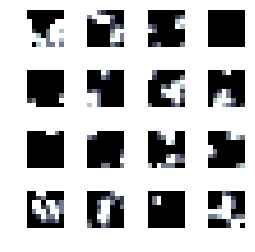

In [17]:
import pylab as py
def show_patches_mat(pre_patches, show_patch_num = 16, display=True):
  
  
    patches = pre_patches
    
    tot_patches = patches.shape[1]
    data_dim = patches.shape[0]
    patch_width = int(np.round(np.sqrt(data_dim)))
  
    # extract show_patch_num patches
    disp_patch = np.zeros([data_dim, show_patch_num], float)
    for i in range(0,show_patch_num):
        patch_i = i * tot_patches // show_patch_num
  
        patch = patches[:,patch_i].copy()
        pmax  = patch.max()
        pmin = patch.min()
        # fix patch range from min to max to 0 to 1
        if pmax > pmin: 
            patch = (patch - pmin) / (pmax - pmin)
        disp_patch[:,i] = patch.copy()

    bw = 5    # border width
    pw = patch_width
  
    patches_y = int(np.sqrt(show_patch_num))
    patches_x = int(np.ceil(float(show_patch_num) / patches_y))
    patch_img = disp_patch.max() * np.ones([(pw + bw) * patches_x - bw,
    patches_y * (pw + bw) - bw], float)
    for i in range(0,show_patch_num): 
        y_i = i // patches_y
        x_i = i % patches_y

        reshaped = disp_patch[:,i].reshape((pw,pw))
        full_patch = np.zeros([pw, pw], float)
        full_patch[0:pw,:] = reshaped[:,:].copy()
        patch_img[x_i*(pw+bw):x_i*(pw+bw)+pw,y_i*(pw+bw):y_i*(pw+bw)+pw] = full_patch
  
    if display:
        py.bone()
        py.imshow(patch_img.T, interpolation='nearest')
        py.axis('off')
    return

show_patches_mat(patches_mat1)


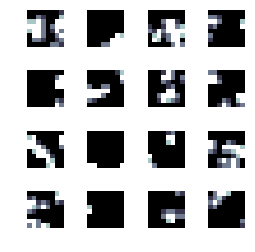

In [23]:
show_patches_mat(patches_mat2)

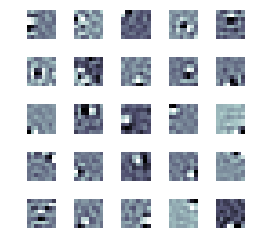

In [20]:
import sklearn.decomposition
icatemp = sklearn.decomposition.FastICA(n_components=32) # note, sensitive to n_components
icafit1 = icatemp.fit(np.transpose(patches_mat1))
icafit2 = icatemp.fit(np.transpose(patches_mat2))
ica_comp1 = icafit1.components_
ica_comp2 = icafit2.components_
# print('shape of the ica component matrix: ',ica_comp.shape)

show_patches_mat(np.transpose(ica_comp1), 25)

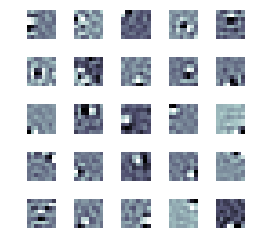

In [21]:
show_patches_mat(np.transpose(ica_comp2), 25)

In [14]:
np.transpose(patches_mat).shape

(1000, 64)

In [29]:
x = np.transpose(ica_comp)

In [30]:
x.shape

(64, 64)

In [7]:
from sklearn.feature_extraction import image

patches1 = image.extract_patches_2d(images[0], (16, 16))
patches2 = image.extract_patches_2d(images[1], (16, 16))

In [8]:
len(patches2)

12769

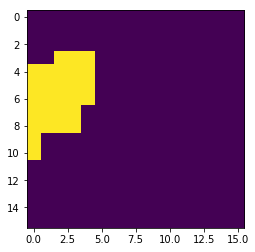

In [9]:
plt.imshow(patches1[0])

In [10]:
from mpl_toolkits.axes_grid1 import AxesGrid

def grid(fig, patches):
    grid = AxesGrid(fig, 110,  # similar to subplot(141)
                    nrows_ncols=(5, 5), # Number of columns and rows
                    axes_pad=0.3, # Distance between grids
                    label_mode="all"
                    )

    Z = patches[0:25]
    for i in range(25):
        im = grid[i].imshow(Z[i], interpolation="nearest")


# Need to turn off plt.axis 

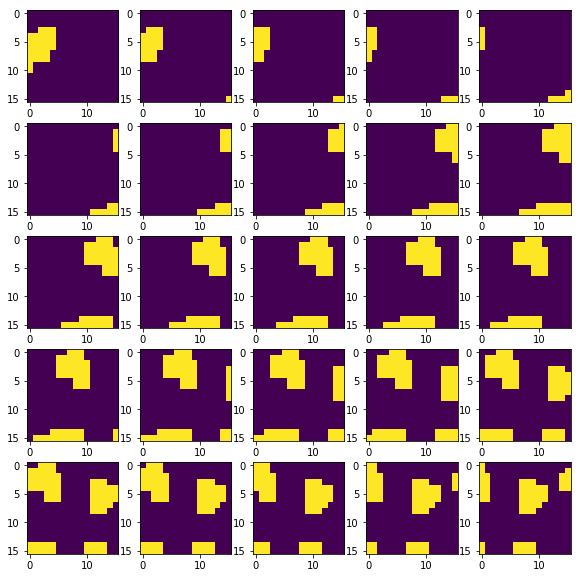

In [11]:
F = plt.figure(1, (20, 10))
F.subplots_adjust(left=0.05, right=0.95)

grid(F, patches1)

# Need to turn off plt.axis 

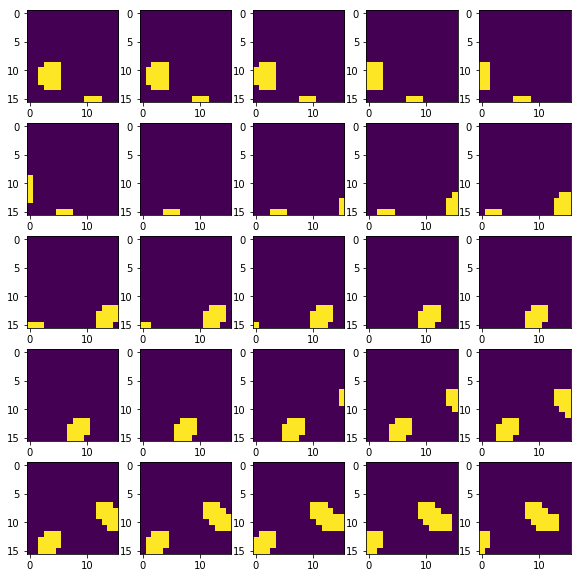

In [12]:
F = plt.figure(1, (20, 10))
F.subplots_adjust(left=0.05, right=0.95)

grid(F, patches2)

In [41]:
def grid2(fig, patches):
    grid = AxesGrid(fig, 110,  # similar to subplot(141)
                    nrows_ncols=(4, 4), # Number of columns and rows
                    axes_pad=0.3, # Distance between grids
                    label_mode="all"
                    )

    Z = patches[0:16]
    for i in range(16):
        im = grid[i].imshow(Z[i], interpolation="nearest")


# Need to turn off plt.axis 

In [15]:
from sklearn.decomposition import FastICA

In [58]:
icatemp = FastICA(n_components=4) # note, sensitive to n_components
icafit = icatemp.fit(patches1[0])

ica_comp = icafit.components_
# print('shape of the ica component

C:\Users\dsaffo\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:312: RuntimeWarning: divide by zero encountered in true_divide
  K = (u / d).T[:n_components]  # see (6.33) p.140
C:\Users\dsaffo\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:312: RuntimeWarning: invalid value encountered in true_divide
  K = (u / d).T[:n_components]  # see (6.33) p.140


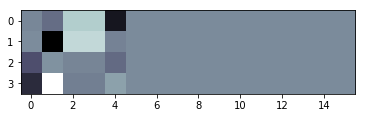

In [59]:
plt.imshow(ica_comp)